In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [80]:
def showImages(images, cols = 2, rows = 3, figsize=(15,10), colorspace='rgb', showOriginal=False):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, img = images[index]
            # color space conversion
            if colorspace == 'gray':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            elif colorspace == 'hsv':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif colorspace == 'hls':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif colorspace == 'lab':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            elif colorspace == 'luv':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif colorspace == 'yuv':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            
            if showOriginal:
                ax.imshow(img)
            else:
                ax.imshow(img, cmap='gray')
            ax.set_title(imagePathName)

In [16]:
# Loading camera calibration
mtx, dist, rvecs, tvecs = pickle.load( open('./cameraCalibration.pickle', 'rb' ) )
# mtx, dist, rvecs, tvecs = cameraCalibration
# mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

In [17]:
# Load test images.
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('./test_images/*.jpg')))

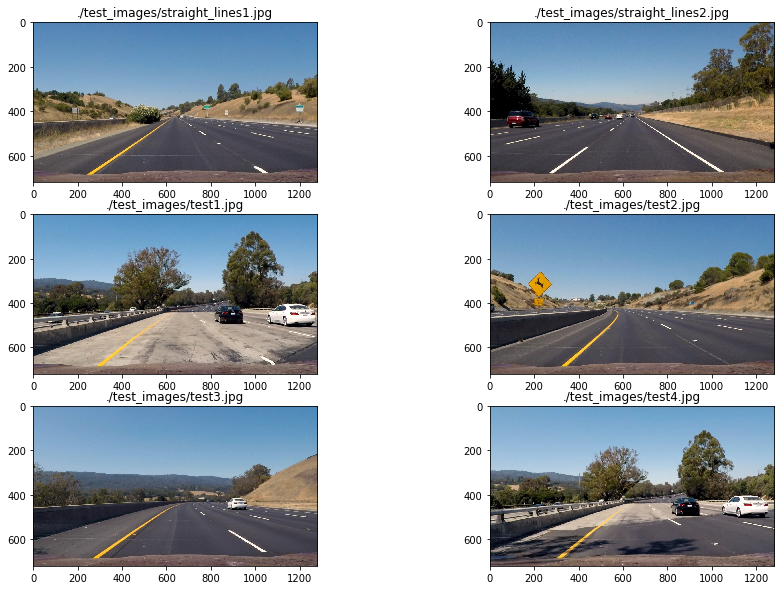

In [81]:
showImages(testImages, showOriginal=True)

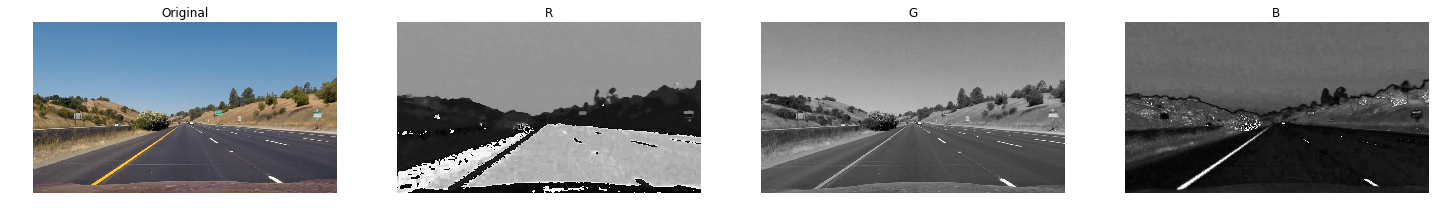

In [31]:
undist = cv2.undistort(testImages[0][1], mtx, dist, None, mtx)
hlsOriginal = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)


fig, axes = plt.subplots(ncols=4, figsize=(25,10))
titles = ['Original', 'R', 'G', 'B']
for index, a in enumerate(axes):
    if index == 0:
        a.imshow(cv2.cvtColor(testImages[0][1], cv2.COLOR_BGR2RGB))
    else:
        a.imshow(hlsOriginal[:,:,index-1], cmap='gray')
    a.axis('off')
    a.set_title(titles[index])

In [125]:
def makeBinaryImage(img, mag_threshold=(0,255), dir_threshold=(0.7, 1.3), mode='simple', sobel_kernel=3):
    '''
    Returns a binary image based on the following inputs
    - threshold
    - threshold mode
    '''
    binary = np.zeros_like(img)
    if mode == 'sobelX':
        sobelX_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        scaled_sobelX = np.uint8(255*sobelX_abs/np.max(sobelX_abs))
        binary[(scaled_sobelX >= mag_threshold[0]) & (scaled_sobelX <= mag_threshold[1])] = 1
    elif mode == 'sobelY':
        sobelY_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        scaled_sobelY = np.uint8(255*sobelY_abs/np.max(sobelY_abs))
        binary[(scaled_sobelY >= mag_threshold[0]) & (scaled_sobelY <= mag_threshold[1])] = 1
    elif mode == 'magnitude':
        sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # calculate the magnitude
        sobel_mag = np.sqrt(np.square(sobelX) + np.square(sobelY))
        # scale to 8-bit (0 - 255) and convert to type = np.uint8
        sobel_scale = np.uint8(255*sobel_mag/np.max(sobel_mag))
        # create a binary mask where mag thresholds are met
        binary[(sobel_scale >= mag_threshold[0]) & (sobel_scale <= mag_threshold[1])] = 1
    elif mode == 'direction':
        sobelX_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        scaled_sobelX = np.uint8(255*sobelX_abs/np.max(sobelX_abs))
        sobelY_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        scaled_sobelY = np.uint8(255*sobelY_abs/np.max(sobelY_abs))
        # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        gradients = np.arctan2(scaled_sobelY, scaled_sobelX)
        binary[(gradients >= dir_threshold[0]) & (gradients <= dir_threshold[1])] = 1
    elif mode == 'mag_dir_combined':
        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        # Calculate the magnitude of gradient
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))

        #Calculate angle
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

        # Create a binary mask where mag thresholds are met
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= mag_threshold[0]) & \
                      (scaled_sobel <= mag_threshold[1]) & \
                      (absgraddir >= dir_threshold[0])   & \
                      (absgraddir <= dir_threshold[1])] = 1
    elif mode == 'grad_color_combined':
        sx_thresh=(20, 100)
        s_thresh=(170, 255)
        # Convert to HLS color space and separate the L and S
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Stack each channel
        binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    elif mode == 'hls':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        binary[(s_channel > mag_threshold[0]) & (s_channel <= mag_threshold[1])] = 1
    else:
        binary[(img >= mag_threshold[0]) & (img <= mag_threshold[1])] = 1  
    return binary

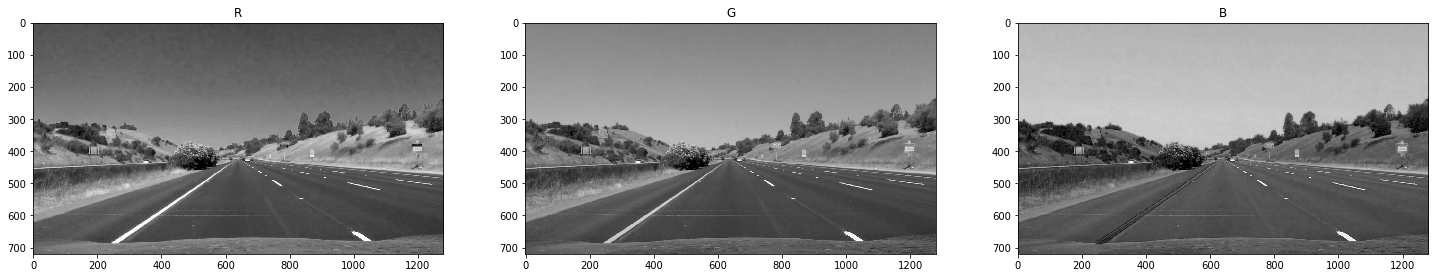

In [46]:
fig, axes = plt.subplots(ncols=3, figsize=(25,10))
for index, ax in enumerate(axes):
    ax.imshow(cv2.cvtColor(testImages[0][1], cv2.COLOR_BGR2RGB)[:, :, index], cmap='gray')
    ax.set_title(titles[index+1])
#plt.imshow(testImages[0][1][:, :, 1])

In [93]:
def applyAndShow(images, mag_threshold=(0,255), dir_threshold=(0.7,1.3), action='simple'):
    """
    Applies `action` to the pair collection `images` (`title`, image) show the images and titles and return
    (`title`, `action`(image))
    """
    output = list(map(lambda img: (img[0], makeBinaryImage(cv2.cvtColor(img[1], cv2.COLOR_BGR2RGB), mag_threshold, dir_threshold, mode=action)), images))
    showImages( output, 2, 3, (15, 13), colorspace='gray')

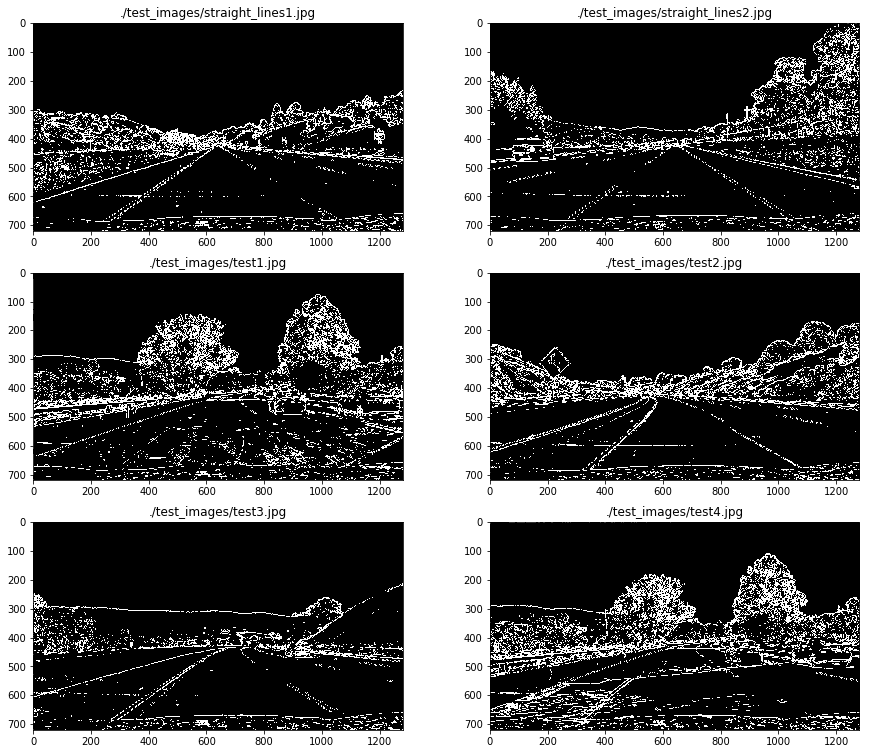

In [120]:
applyAndShow(testImages, mag_threshold=(20,100), action='magnitude')

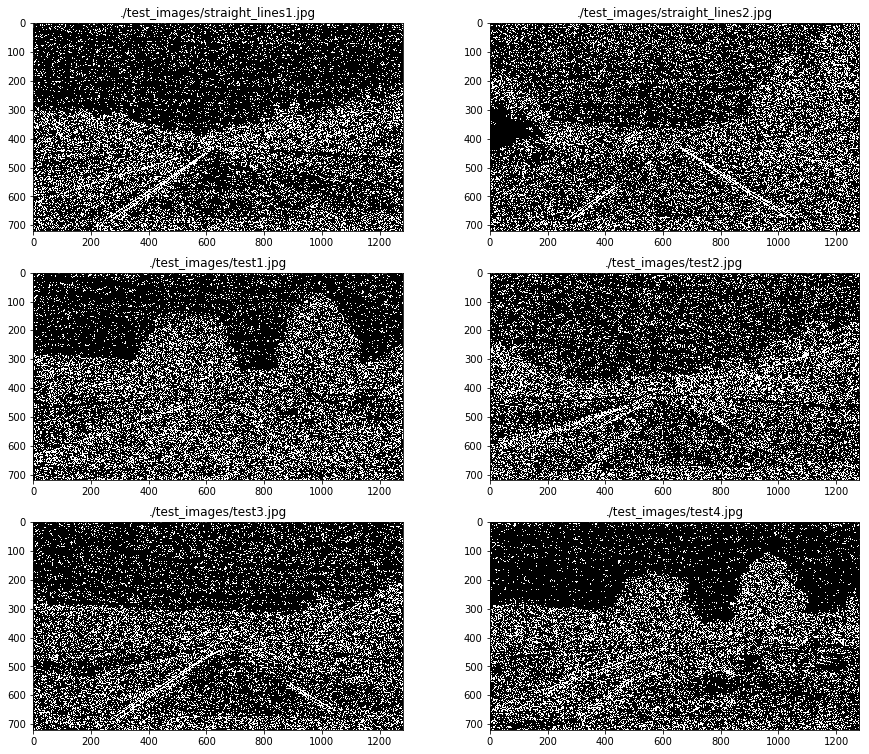

In [96]:
applyAndShow(testImages, dir_threshold=(0.7, 1.3), action='direction')

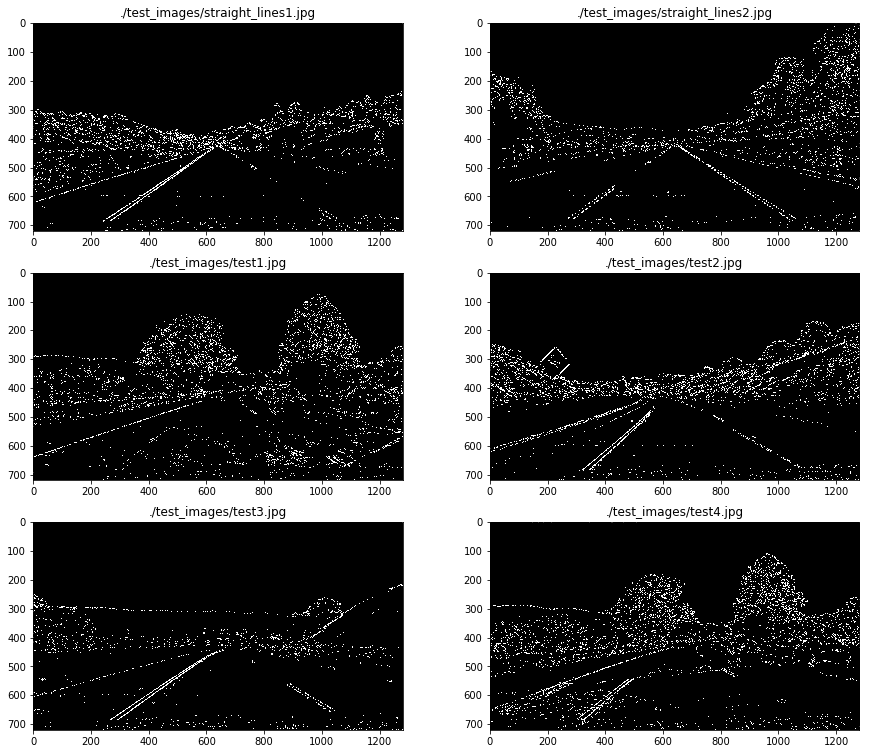

In [122]:
applyAndShow(testImages,  mag_threshold=(20,150), dir_threshold=(0.7,1.3), action='mag_dir_combined')

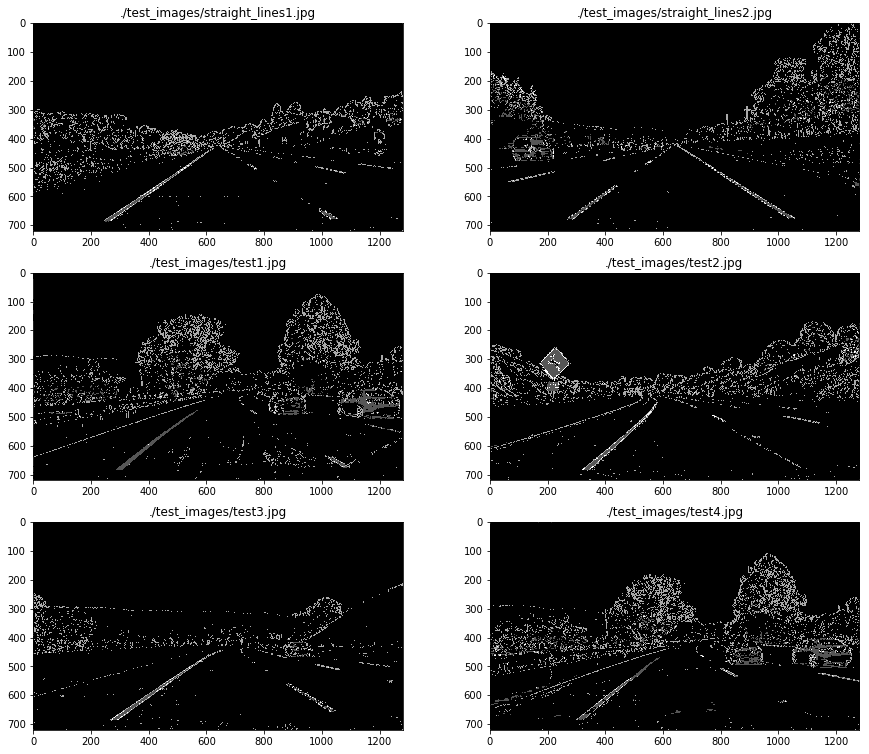

In [124]:
applyAndShow(testImages, action='grad_color_combined')